In [1]:
import hdbscan
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import re
import seaborn as sns
import time
import umap
import warnings
from sentence_transformers import models, SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
warnings.filterwarnings("ignore")

In [2]:
# Load data
with open('ml_cite.json', 'r') as f:
    cites = json.load(f)
    
with open('ml_abstract.pkl', 'rb') as fa:
    abstracts = pickle.load(fa)

with open('ml_title.pkl', 'rb') as ft:
    titles = pickle.load(ft)

In [3]:
REPLACE_DICT = {
    "large language models (llms)": "large language models",
    "large language model (llm)": "large language models",
    "llms": "large language models",
    "llm": "large language models",
    "state of the art ": "",
    "state-of-the-art ": "",
    "https:": "",
}

def replace_txt(text):
    for k, v in REPLACE_DICT.items():
        text = text.lower().replace(k, v)
    return text

def select_ids(cites, n):
    ids = []
    for k, v in cites.items():
        if v >= n:
            ids.append(k)
    return ids

In [4]:
# Preprocess data
top_papers = select_ids(cites, 2)
top_abstract = [titles[x] + '. ' + abstracts[x].rstrip() for x in top_papers] # combine title and abstract
top_abstract = [x.replace('\n', ' ') for x in top_abstract] # remove newline
top_abstract = [re.sub(' +', ' ', x) for x in top_abstract] # remove spaces
top_abstract = [re.sub('\$.[^$]*\$', '', x) for x in top_abstract] # remove latex equation
top_abstract = [replace_txt(x) for x in top_abstract] # replace abbreviations
print(f"Selected {len(top_papers)} papers for preprocessing")

Selected 539 papers for preprocessing


In [5]:
def load_sentence_transformer():
    """ Load a pre-trained Sentence Transformers model from Hugging Face """
    embedding_model = models.Transformer(model_name_or_path='sentence-transformers/all-MiniLM-L6-v2',
                                         max_seq_length=512,
                                         do_lower_case=True)
    pooling_model = models.Pooling(embedding_model.get_word_embedding_dimension(),
                                   pooling_mode_mean_tokens=True,
                                   pooling_mode_cls_token=False,
                                   pooling_mode_max_tokens=False)
    return SentenceTransformer(modules=[embedding_model, pooling_model])

def doc_encode(doc,
               dump_file=None,
               show_progress=False):
    tic = time.time()
    model = load_sentence_transformer()
    embeddings = model.encode(doc, show_progress_bar=show_progress)
    print(f"Embedding size: {embeddings.shape}")
    
    if dump_file:
        with open(dump_file, 'wb') as fe:
            pickle.dump(embeddings, fe)
    toc = time.time()
    print(f"Run time: {int(toc-tic)} sec")
    
    return embeddings

In [6]:
# Create embeddings
embeddings = doc_encode(top_abstract, dump_file='ml_embed.pkl')

Embedding size: (539, 384)
Run time: 109 sec


In [7]:
def umap_reducer(embeddings,
                 n_components,
                 n_neighbors=8,
                 metric='euclidean'):
    return umap.UMAP(n_neighbors=n_neighbors,
                     n_components=n_components,
                     min_dist=0.0,
                     metric=metric,
                     random_state=42).fit_transform(embeddings)
    
def topic_cluster(umap_embeddings,
                  min_cluster_size,
                  min_samples,
                  metric='euclidean',
                  cluster_selection_method='eom'):
    cluster = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size,
                              min_samples=min_samples,
                              metric=metric,
                              cluster_selection_method='eom').fit(umap_embeddings)
    print_cluster(cluster)
    return cluster

def print_cluster(cluster):
    unique_elements, counts_elements = np.unique(cluster.labels_, return_counts=True)
    count_outliers = counts_elements[0]
    print("Paper counts:")
    if unique_elements[0] == -1:
        print(f"1 outlier topic: {counts_elements[0]}")
        print(f"{len(unique_elements)-1} clustered topics: {counts_elements[1:]}")
    else:
        print(f"{len(unique_elements)} clustered topics: {counts_elements}")

In [8]:
# Cluster embeddings    
umap_embed = umap_reducer(embeddings,
                          n_components=20)

cluster = topic_cluster(umap_embed,
                        min_cluster_size=15,
                        min_samples=5)

Paper counts:
1 outlier topic: 117
10 clustered topics: [47 20 60 20 31 54 81 33 27 49]


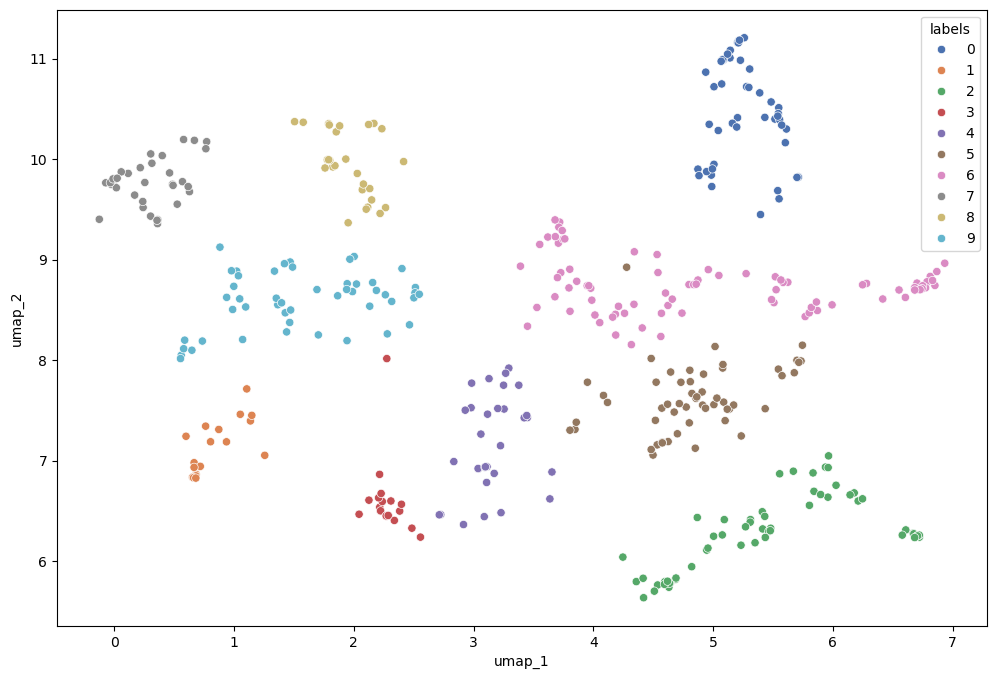

In [9]:
# Visualize embeddings
umap_plot = umap_reducer(embeddings,
                         n_components=2)
result = pd.DataFrame(umap_plot, columns=['umap_1', 'umap_2'])
result['labels'] = cluster.labels_

fig, ax = plt.subplots(figsize=(12, 8))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
sns.scatterplot(data=clustered,
                x="umap_1",
                y="umap_2",
                hue="labels",
                palette="deep")
plt.show()

In [10]:
def create_doc_df(top_abstract, cluster):
    dict = {'Doc': top_abstract, 'Topic': cluster.labels_}
    df = pd.DataFrame(dict)
    return df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

docs_per_topic = create_doc_df(top_abstract, cluster)
docs_per_topic.head()

,Topic,Doc
0,-1,stable audio open. open generative models are ...
1,0,what makes and breaks safety fine-tuning? a me...
2,1,cardiolab: laboratory values estimation from e...
3,2,adaptive user journeys in pharma e-commerce wi...
4,3,inferring turbulent velocity and temperature f...


In [11]:
def c_tf_idf(documents, m, ngram_range):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)
    return tf_idf, count

def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n):
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = 100*tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

In [12]:
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(top_abstract), ngram_range=(2,2))
top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, 5)
top_n_words

{-1: [('github com', 0.3268156939712563),
  ('diffusion models', 0.32285284451157453),
  ('time series', 0.3146460086765825),
  ('segment model', 0.2846979003738571),
  ('multi modal', 0.2767398940528095)],
 0: [('adversarial attacks', 0.7725264960883372),
  ('anomaly detection', 0.7284254475662406),
  ('adversarial examples', 0.5876263392175335),
  ('literal copying', 0.5876263392175335),
  ('target large', 0.558812742230307)],
 1: [('mimic iv', 0.8667180849027588),
  ('ecg fm', 0.8667180849027588),
  ('sepsis patients', 0.8667180849027588),
  ('contrastive learning', 0.7433947981650126),
  ('mortality risk', 0.7264327718206084)],
 2: [('reinforcement learning', 1.2319690889844397),
  ('ai systems', 0.7069202439372313),
  ('ai governance', 0.632991918112463),
  ('multi agent', 0.6029196685519651),
  ('decision making', 0.5938711423313152)],
 3: [('kolmogorov arnold', 2.3407289756500145),
  ('arnold networks', 2.2784375194266824),
  ('machine learning', 1.1293954536181103),
  ('dynamic